<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/GoogLeNet_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

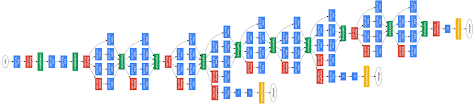

The paper for InceptionNet/GoogleNet can be found here:

`It's called "Going Deeper with Convolutions"`

https://arxiv.org/abs/1409.4842

Some features to remember include:

- The paper has auxiliary classifiers on the sides during TRAINING- the idea behind it was to improve the regularization of the network; 
- By doing this, we're trying to make sure that the layers up to that point are actually doing something useful; one motivation was to reduce the ability of the network to overfit

- The InceptionNet uses 1x1, 3x3 and 5x5 blocks
- Before the 3x3 and 5x5 blocks, there's a "reduction" 1x1 block since 3x3 and 5x5 are already so computationally expensive

A paragraph I found important from the paper was:

 _We assume that each unit from the earlier layer corresponds to some region of the input image and these
units are grouped into filter banks. In the lower layers (the ones close to the input) correlated units
would concentrate in local regions. This means, we would end up with a lot of clusters concentrated
in a single region and they can be covered by a layer of 1×1 convolutions in the next layer, as
suggested in [12]. However, one can also expect that there will be a smaller number of more
spatially spread out clusters that can be covered by convolutions over larger patches, and there
will be a decreasing number of patches over larger and larger regions. In order to avoid patchalignment issues, current incarnations of the Inception architecture are restricted to filter sizes 1×1,
3×3 and 5×5, however this decision was based more on convenience rather than necessity. It also
means that the suggested architecture is a combination of all those layers with their output filter
banks concatenated into a single output vector forming the input of the next stage. Additionally,
since pooling operations have been essential for the success in current state of the art convolutional
networks, it suggests that adding an alternative parallel pooling path in each such stage should have
additional beneficial effect, too._

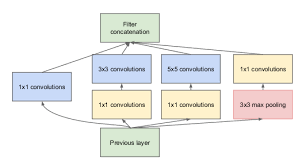

In [2]:

# Create a reusable conv block that has 1x1, 3x3 and 5x5 since the paper uses all of this and combines their
# output in the next layer

# The Inception Block USES the ConvBlock

class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()

    # there are going to be FOUR branches:
    # 1x1
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1,1))
    # 3x3
    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1)
    )
    # 5x5
    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, stride=1, padding=2)
    )
    # maxPool
    self.branch4 = nn.Sequential(
         nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
         conv_block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x):
    # concatenate all of the filters in branches 1 through 4
    # we didn't change the image size; it's going to be 28x28 from every output branch
    # but we did change the number of filters

    # number of images x filters x 28 x 28
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x))) #conv --> batchnorm --> relu

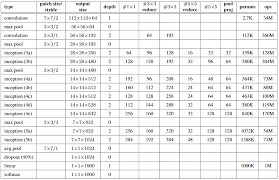

In [3]:
class GoogLeNet(nn.Module):
  def __init__(self,in_channels=3, num_classes=1000):
    super(GoogLeNet, self).__init__()

    # these are all the standard conv blocks before we use the Inception Block
    self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7),
                              stride=(2,2), padding=(3,3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=(3,3),
                              stride=(1,1), padding=(1,1))
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # start the inception block here--
    # the order is as follows--
    # in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 1000)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return x



In [4]:
x= torch.randn(3,3,224,224)
model = GoogLeNet()
print(model(x).shape)

torch.Size([3, 1000])
